# Akbank Derin √ñƒürenme Bootcamp - Pneumonia Hastalƒ±ƒüƒ± Tahmini 

## ƒ∞√ßindekiler
1. [**Proje Hakkƒ±nda**](#1)  
2. [**Hiperparametre Optimizasyonu**](#2)  
3. [**Veri Y√ºkleme** ](#3)
4. [**Veri G√∂rselle≈ütirme** ](#4)  
5. [**Veri √ñni≈üleme ve Hazƒ±rlƒ±k**](#5)
6. [**Model Tasarƒ±mƒ± ve Eƒüitimi**](#6)
7. [**Model Deƒüerlendirmesi**](#7)

***

## 1. Proje Hakkƒ±nda
<a id="1"></a>

### 1.1 Proje Amacƒ±

    Sorun Tanƒ±mƒ±
    G√∂ƒü√ºs r√∂ntgeni g√∂r√ºnt√ºlerinden pn√∂moni te≈ühisi koymak, radyolojistler i√ßin zaman alƒ±cƒ± ve uzmanlƒ±k gerektiren bir s√ºre√ßtir. Manuel deƒüerlendirme s√ºre√ßleri hem zaman kaybƒ±na hem de insan kaynaklƒ± hatalara yol a√ßabilmektedir. Mevcut binlerce g√∂ƒü√ºs r√∂ntgeni g√∂r√ºnt√ºs√ºn√ºn manuel olarak deƒüerlendirilmesi √∂nemli bir i≈ü y√ºk√º olu≈üturmaktadƒ±r.

    G√∂revim
    Bu proje kapsamƒ±nda, g√∂ƒü√ºs r√∂ntgeni g√∂r√ºnt√ºlerinden pn√∂moni varlƒ±ƒüƒ±nƒ± otomatik tespit edebilen bir CNN modeli geli≈ütirmeyi planlƒ±yorum. 5,863 adet r√∂ntgen g√∂r√ºnt√ºs√º kullanarak NORMAL ve PNEUMONIA sƒ±nƒ±flarƒ± arasƒ±nda tahmin yapan bir model olu≈üturacaƒüƒ±m.

### 1.2 Veri Seti Bilgisi

    Temel √ñzellikler
    * Veri Seti: Chest X-Ray Images (Pneumonia)
    * Toplam G√∂r√ºnt√º: 5,863 adet JPEG r√∂ntgen g√∂r√ºnt√ºs√º
    * Sƒ±nƒ±flar: 2 sƒ±nƒ±f (NORMAL, PNEUMONIA)
    * B√∂l√ºmler: train, test, validation setleri

    Kaynak ve Kalite:
    * Hastane: Guangzhou Women and Children's Medical Center* 
    * Ya≈ü Grubu: 1-5 ya≈ü pediatrik hastalar
    * Doƒürulama: ƒ∞ki uzman hekim tarafƒ±ndan etiketlenmi≈ü
    * Veri Seti: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

***


## 2. Hiperparametre Optimizasyonu
<a id="2"></a>

    Gerekli olduƒüunu d√º≈ü√ºn√ºƒü√ºm t√ºm k√ºt√ºphanleri ekledim.

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from keras.preprocessing import image
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


    ƒ∞lk olarak modelimin en iyi sonu√ß veren hiperparametreleri bulmakla ba≈ülamak istedim. √á√ºnk√º ilerideki adƒ±mlarda aklƒ±mda soru i≈üreti kalmasƒ±nƒ± istemedim.

    Bu a≈üamada farklƒ± optimizat√∂rlerin (SGD, Momentum, Adam, RMSprop) performanslarƒ±nƒ± kar≈üƒ±la≈ütƒ±rarak modelimin doƒüruluk oranlarƒ± √ºzerindeki etkilerini g√∂zlemledim.


In [4]:
def comparison_of_optimizers():
    def prepare_data():
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
            image_size=(150, 150),
            batch_size=1000,
            label_mode='binary',
            color_mode='grayscale'
        )
        
        X, y = [], []
        for images, labels in train_ds:
            X.append(images.numpy())
            y.append(labels.numpy())
        
        X = np.concatenate(X, axis=0)
        y = np.concatenate(y, axis=0)
        
        X = X / 255.0
        
        print(f"X shape: {X.shape}, y shape: {y.shape}")
        return X, y
    
    X, y = prepare_data()
    
    optimizers = {
        'SGD': keras.optimizers.SGD(learning_rate=0.001),
        'Momentum': keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
        'Adam': keras.optimizers.Adam(learning_rate=0.001),
        'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001)
    }
    
    plt.figure(figsize=(12, 8))
    
    for opt_name, optimizer in optimizers.items():
        # CNN modeli olu≈ütur
        model = keras.Sequential([
            keras.layers.Conv2D(32, 3, activation='relu', input_shape=(150, 150, 1)),
            keras.layers.MaxPooling2D(),
            keras.layers.Conv2D(64, 3, activation='relu'),
            keras.layers.MaxPooling2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
    
        model.compile(optimizer=optimizer,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    
        history = model.fit(X, y, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
    
        plt.plot(history.history['val_accuracy'], label=opt_name, linewidth=2)
        print(f"{opt_name}: Final Val Acc = {history.history['val_accuracy'][-1]:.4f}")
    
    plt.title('Optimizer Kar≈üƒ±la≈ütƒ±rmasƒ±', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Doƒüruluk')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Found 5216 files belonging to 2 classes.


I0000 00:00:1758812138.871551      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


X shape: (5216, 150, 150, 1), y shape: (5216, 1)


I0000 00:00:1758812158.195755     102 service.cc:148] XLA service 0x7ee020005c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758812158.196443     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758812158.381762     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758812160.479192     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


SGD: Final Val Acc = 0.9502
Momentum: Final Val Acc = 0.9674
Adam: Final Val Acc = 0.9808
RMSprop: Final Val Acc = 0.9789


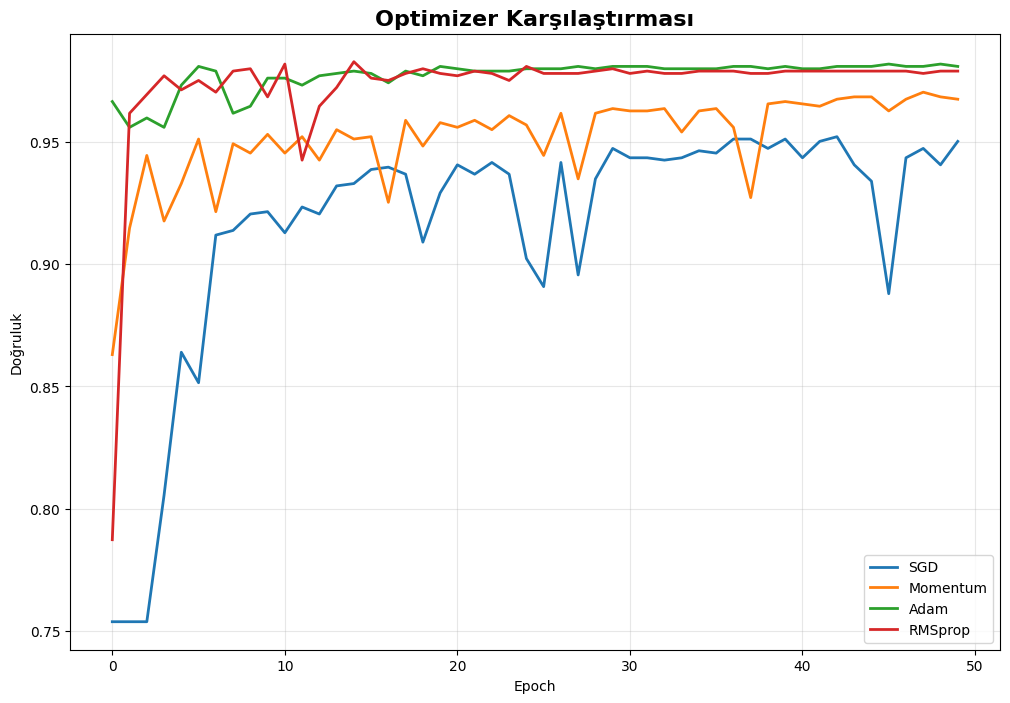

In [5]:
comparison_of_optimizers()

    En iyi sonu√ß veren optimizat√∂rlerin Adam ve RMSsprop olarak kar≈üƒ±ma √ßƒ±ktƒ±. Ancak 10. epochta RMSsprop'un ani d√º≈ü√º≈ü√º y√ºz√ºnden Adam ile devam ettim.

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def hyperparameter_optimization(img_size):
    def prepare_data():
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
            image_size=(img_size, img_size),
            batch_size=1000,
            label_mode='binary',
            color_mode='grayscale'
        )
        
        X, y = [], []
        for images, labels in train_ds:
            X.append(images.numpy())
            y.append(labels.numpy())
        
        X = np.concatenate(X, axis=0)
        y = np.concatenate(y, axis=0)
        
        X = X / 255.0
        
        print(f"X shape: {X.shape}, y shape: {y.shape}")
        return X, y

    
    X, y = prepare_data()
    
    learning_rates = [0.001, 0.01, 0.1]
    batch_sizes = [16, 32, 64]
    
    results = {}
    
    for lr in learning_rates:
        for batch_size in batch_sizes:
            model = keras.Sequential([
                keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_size, img_size, 1)),
                keras.layers.MaxPooling2D(),
                keras.layers.Conv2D(64, 3, activation='relu'),
                keras.layers.MaxPooling2D(),
                keras.layers.Flatten(),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(1, activation='sigmoid')
            ])
    
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
    
            history = model.fit(X, y, epochs=10, batch_size=batch_size, verbose=0, validation_split=0.2)
    
            results[f'lr_{lr}_bs_{batch_size}'] = history.history['val_accuracy'][-1]
            print(f"lr_{lr}_bs_{batch_size}: {results[f'lr_{lr}_bs_{batch_size}']:.4f}")
    
    best_result = max(results.items(), key=lambda x: x[1])
    print(f"\nüèÜ En iyi: {best_result[0]} = {best_result[1]:.4f}")
    
    return results

In [7]:
results = hyperparameter_optimization(64)

Found 5216 files belonging to 2 classes.
X shape: (5216, 64, 64, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9646
lr_0.001_bs_32: 0.9655
lr_0.001_bs_64: 0.9741
lr_0.01_bs_16: 0.9703
lr_0.01_bs_32: 0.9713
lr_0.01_bs_64: 0.9674
lr_0.1_bs_16: 0.7605
lr_0.1_bs_32: 0.7605
lr_0.1_bs_64: 0.7605

üèÜ En iyi: lr_0.001_bs_64 = 0.9741


In [8]:
results = hyperparameter_optimization(128)

Found 5216 files belonging to 2 classes.
X shape: (5216, 128, 128, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9674
lr_0.001_bs_32: 0.9761
lr_0.001_bs_64: 0.9761
lr_0.01_bs_16: 0.7452
lr_0.01_bs_32: 0.9301
lr_0.01_bs_64: 0.9713
lr_0.1_bs_16: 0.7452
lr_0.1_bs_32: 0.7452
lr_0.1_bs_64: 0.7452

üèÜ En iyi: lr_0.001_bs_32 = 0.9761


In [9]:
results = hyperparameter_optimization(150)

Found 5216 files belonging to 2 classes.
X shape: (5216, 150, 150, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9741
lr_0.001_bs_32: 0.9761
lr_0.001_bs_64: 0.9761
lr_0.01_bs_16: 0.9550
lr_0.01_bs_32: 0.9579
lr_0.01_bs_64: 0.9732
lr_0.1_bs_16: 0.7222
lr_0.1_bs_32: 0.7222
lr_0.1_bs_64: 0.7222

üèÜ En iyi: lr_0.001_bs_32 = 0.9761


In [10]:
results = hyperparameter_optimization(224)

Found 5216 files belonging to 2 classes.
X shape: (5216, 224, 224, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9780
lr_0.001_bs_32: 0.9377
lr_0.001_bs_64: 0.9818
lr_0.01_bs_16: 0.9588
lr_0.01_bs_32: 0.9531
lr_0.01_bs_64: 0.8736
lr_0.1_bs_16: 0.7605
lr_0.1_bs_32: 0.7605
lr_0.1_bs_64: 0.7605

üèÜ En iyi: lr_0.001_bs_64 = 0.9818


In [11]:
results = hyperparameter_optimization(256)

Found 5216 files belonging to 2 classes.
X shape: (5216, 256, 256, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9693
lr_0.001_bs_32: 0.9722
lr_0.001_bs_64: 0.9674
lr_0.01_bs_16: 0.7443
lr_0.01_bs_32: 0.8784
lr_0.01_bs_64: 0.7443
lr_0.1_bs_16: 0.7443
lr_0.1_bs_32: 0.7443
lr_0.1_bs_64: 0.7443

üèÜ En iyi: lr_0.001_bs_32 = 0.9722


    Bu adƒ±mda hiperparametre optimizasyonu ger√ßekle≈ütirdim. Farklƒ± √∂ƒürenme oranlarƒ± (0.001, 0.01, 0.1) ve batch size deƒüerleri (16, 32, 64) ile modeli tekrar tekrar eƒüittim. Her kombinasyon i√ßin doƒürulama doƒüruluk deƒüerlerini kaydederek, en y√ºksek sonucu veren ayarlarƒ± se√ßtim. B√∂ylece modelin performansƒ±nƒ± artƒ±rmak i√ßin en uygun hiperparametreleri belirlemi≈ü oldum.

    Ve o sonu√ßlar da a≈üagƒ±dadƒ±r.

In [12]:
# Dataset parameters
IMG_SIZE = (150, 150)
BATCH_SIZE = 64
LEARNING_RATE = 0.001

***

## 3. Veri Y√ºkleme
<a id="3"></a>

    Bu a≈üamada verileri train, validation ve test seti olarak ayƒ±rdƒ±m. Eƒüitim setinin %10‚Äôunu doƒürulama i√ßin ayƒ±rarak modelin eƒüitim s√ºrecinde performansƒ±nƒ± takip etmeyi saƒüladƒ±m. T√ºm g√∂rselleri gri tonlamalƒ± (grayscale) olacak ≈üekilde aynƒ± boyuta getirdim ve batch‚Äôler halinde y√ºkledim.


In [13]:
# Preprocessing the Training set
train = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    validation_split=0.1,   # %10 validation
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    color_mode='grayscale'
)

# Preprocessing the Test set
test = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    color_mode='grayscale'
)

# Preprocessing the Validation set
val = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    validation_split=0.1,   # %10 validation
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    color_mode='grayscale'
)

Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 624 files belonging to 2 classes.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.


    Verilerimi etiketlebilmek i√ßin sƒ±nƒ±f isimlerimi bir deƒüiken de tuttum.

In [14]:
# Class names
class_names = train.class_names
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


***

## 4. Veri G√∂rselle≈ütirme
<a id="4"></a>

### Analiz edilecek konular:
* **Sƒ±nƒ±f daƒüƒ±lƒ±mlarƒ±** - Her veri setinde ka√ß NORMAL ve PNEUMONIA √∂rneƒüi var
* **Veri dengesizliƒüi** - Sƒ±nƒ±flar arasƒ± dengesizlik var mƒ±
* **G√∂r√ºnt√º boyutlarƒ±** - Orijinal g√∂r√ºnt√ºlerin boyut daƒüƒ±lƒ±mlarƒ±
* **√ñrnek g√∂r√ºnt√ºler** - Her sƒ±nƒ±ftan sample g√∂r√ºnt√ºler

In [15]:
def analyze_class_distribution(dataset, data_name):
    normal_count = 0
    pneumonia_count = 0
    total_samples = 0
    
    for images, labels in dataset:
        for label in labels:
            if label.numpy() == 1:
                pneumonia_count+= 1
            else:
                normal_count += 1
            total_samples += 1
    
    print(f"\nüìä {data_name} Seti Analizi:")
    print(f"    NORMAL: {normal_count} g√∂r√ºnt√º")
    print(f"    PNEUMONIA: {pneumonia_count} g√∂r√ºnt√º")
    print(f"    Toplam: {total_samples} g√∂r√ºnt√º")
    print(f"    PNEUMONIA oranƒ±: %{pneumonia_count/total_samples*100:.2f}")
    
    return normal_count, pneumonia_count

train_normal, train_pneumonia = analyze_class_distribution(train, "TRAIN")
test_normal, test_pneumonia = analyze_class_distribution(test, "TEST") 
val_normal, val_pneumonia = analyze_class_distribution(val, "VALIDATION")


üìä TRAIN Seti Analizi:
    NORMAL: 1218 g√∂r√ºnt√º
    PNEUMONIA: 3477 g√∂r√ºnt√º
    Toplam: 4695 g√∂r√ºnt√º
    PNEUMONIA oranƒ±: %74.06

üìä TEST Seti Analizi:
    NORMAL: 234 g√∂r√ºnt√º
    PNEUMONIA: 390 g√∂r√ºnt√º
    Toplam: 624 g√∂r√ºnt√º
    PNEUMONIA oranƒ±: %62.50

üìä VALIDATION Seti Analizi:
    NORMAL: 123 g√∂r√ºnt√º
    PNEUMONIA: 398 g√∂r√ºnt√º
    Toplam: 521 g√∂r√ºnt√º
    PNEUMONIA oranƒ±: %76.39


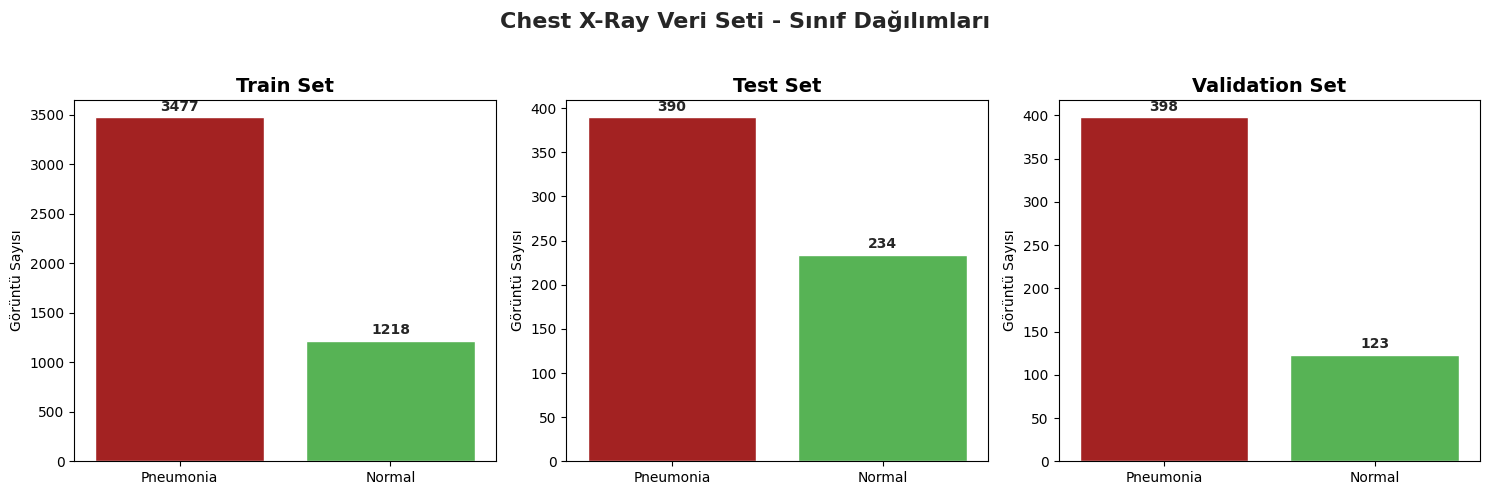

In [16]:
train_counts = [train_pneumonia, train_normal]
test_counts = [test_pneumonia, test_normal]
val_counts = [val_pneumonia, val_normal]

datasets = [train_counts, test_counts, val_counts]
titles = ["Train Set", "Test Set", "Validation Set"]
labels = ["Pneumonia", "Normal"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style('darkgrid')

for i, (counts, title) in enumerate(zip(datasets, titles)):
    sns.barplot(x=labels, y=counts, ax=axes[i], palette=['#b80d0d', '#48c246'])
    axes[i].set_title(title, fontsize=14, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("G√∂r√ºnt√º Sayƒ±sƒ±")
    
    for j, count in enumerate(counts):
        axes[i].text(j, count + max(counts)*0.01, str(count), 
                    ha='center', va='bottom', fontweight='bold')

plt.suptitle("Chest X-Ray Veri Seti - Sƒ±nƒ±f Daƒüƒ±lƒ±mlarƒ±", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

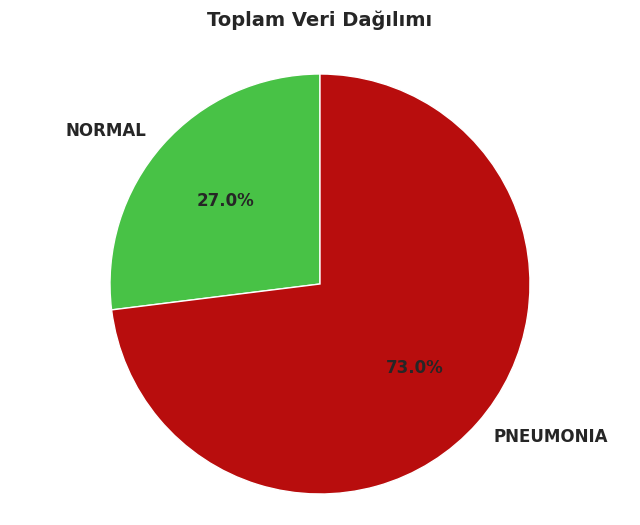

In [17]:
total_normal = train_normal + test_normal + val_normal
total_pneumonia = train_pneumonia + test_pneumonia + val_pneumonia

colors = ['#48c246', '#b80d0d']

plt.figure(figsize=(8, 6))
plt.pie([total_normal, total_pneumonia], 
        labels=['NORMAL', 'PNEUMONIA'], 
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Toplam Veri Daƒüƒ±lƒ±mƒ±', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.show()

In [18]:
print("\nüìè G√∂r√ºnt√º Boyut Bilgisi:")
print(f"   ƒ∞≈ülenmi≈ü boyut: {IMG_SIZE[0]}x{IMG_SIZE[1]} piksel")
print(f"   Toplam piksel: {IMG_SIZE[0] * IMG_SIZE[1]:,}")
print(f"   Renk kanalƒ±: Grayscale (1 kanal)")


üìè G√∂r√ºnt√º Boyut Bilgisi:
   ƒ∞≈ülenmi≈ü boyut: 150x150 piksel
   Toplam piksel: 22,500
   Renk kanalƒ±: Grayscale (1 kanal)


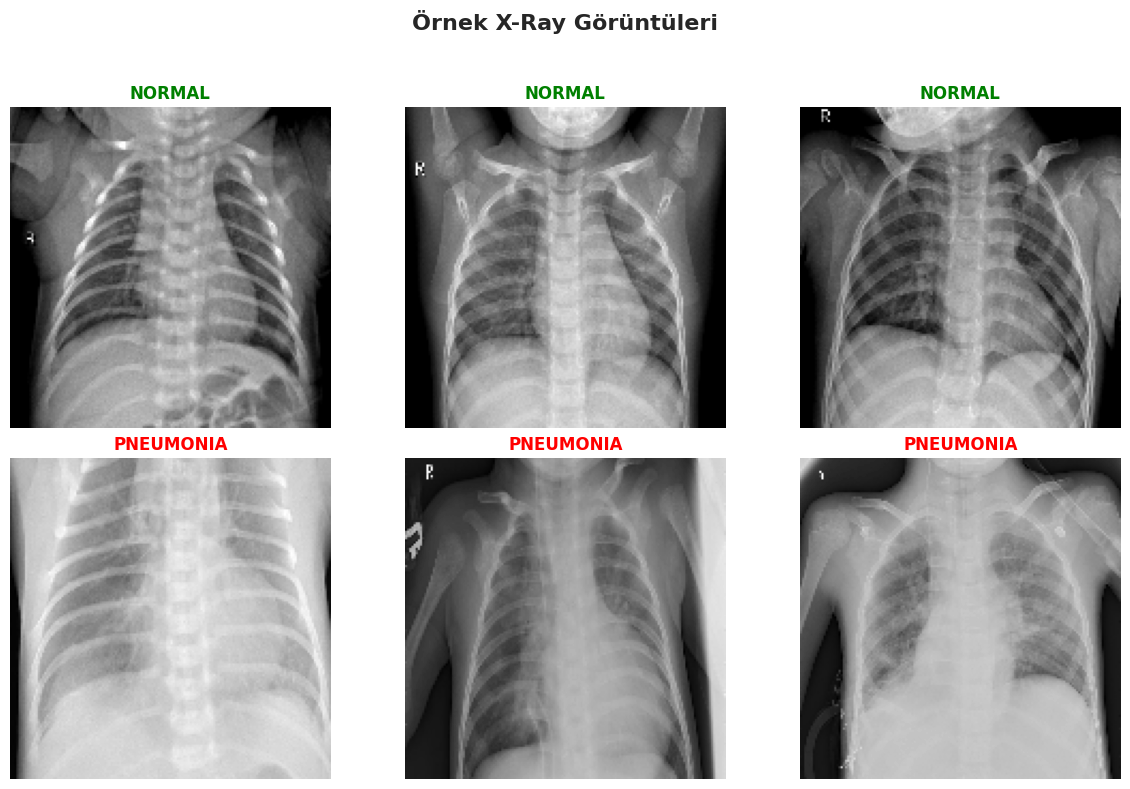

In [19]:
def get_sample_images(dataset, num_samples=3):
    normal_samples = []
    pneumonia_samples = []
    
    for images, labels in dataset.take(10):
        for i in range(images.shape[0]):
            if len(normal_samples) < num_samples and labels[i].numpy() == 0:
                normal_samples.append(images[i].numpy())
            elif len(pneumonia_samples) < num_samples and labels[i].numpy() == 1:
                pneumonia_samples.append(images[i].numpy())
            
            if len(normal_samples) == num_samples and len(pneumonia_samples) == num_samples:
                break
        if len(normal_samples) == num_samples and len(pneumonia_samples) == num_samples:
            break
    
    return normal_samples, pneumonia_samples

normal_samples, pneumonia_samples = get_sample_images(train)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normal
for i, sample in enumerate(normal_samples):
    axes[0, i].imshow(sample.squeeze(), cmap='gray')  # squeeze() grayscale i√ßin
    axes[0, i].set_title('NORMAL', fontsize=12, color='green', fontweight='bold')
    axes[0, i].axis('off')

# Pneumonia
for i, sample in enumerate(pneumonia_samples):
    axes[1, i].imshow(sample.squeeze(), cmap='gray')
    axes[1, i].set_title('PNEUMONIA', fontsize=12, color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle('√ñrnek X-Ray G√∂r√ºnt√ºleri', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

    Verisetimiden birka√ß tane √∂rneƒüi √ºst kƒ±sƒ±mda g√∂rebilirsiniz.

    Analizlerimin sonucunda veri setimin olduk√ßa dengesiz olduƒüunu fark ettim. PNEUMONIA √∂rnekleri NORMAL √∂rneklerden √ßok daha fazla, bu da modelimin yanlƒ±≈ü √∂ƒürenmesine sebep olabilir. Bu sorunu √ß√∂zmek i√ßin Data Augmentation yaparak veri setimi dengelemeyi planlƒ±yorum.

***

## 5. Veri √ñni≈üleme ve Hazƒ±rlƒ±k
<a id="5"></a>


    Bu adƒ±mda t√ºm piksel deƒüerlerini 0-255 aralƒ±ƒüƒ±ndan 0-1 aralƒ±ƒüƒ±na d√∂n√º≈üt√ºrerek verileri normalize ettim. B√∂ylece modelin daha hƒ±zlƒ± ve kararlƒ± ≈üekilde √∂ƒürenmesini saƒüladƒ±m.


In [20]:
# Normalization
train = train.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test = test.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
val = val.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

    Bu adƒ±mda veri artƒ±rma (data augmentation) uyguladƒ±m. G√∂rselleri yatay olarak √ßevirdim, ¬±10 derece d√∂nd√ºrd√ºm, %10 yakƒ±nla≈ütƒ±rma/uzakla≈ütƒ±rma yaptƒ±m ve kontrastlarƒ±nƒ± deƒüi≈ütirdim. B√∂ylece modelin farklƒ± varyasyonlara kar≈üƒ± daha dayanƒ±klƒ± olmasƒ±nƒ± saƒüladƒ±m.


In [21]:
# Data Augmentation 
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),     #
    RandomRotation(0.1),          
    RandomZoom(0.1),              
    RandomContrast(0.1)           
])

    Bu adƒ±mda performans optimizasyonu i√ßin verileri √∂nceden y√ºkleme (prefetch) yaptƒ±m. B√∂ylece veri hazƒ±rlanƒ±rken model aynƒ± anda eƒüitim yaparak i≈ülem s√ºresini kƒ±salttƒ±m.


In [22]:
# Performance optimization
train = train.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)

    A≈üaƒüƒ±da Data Augmentation sonucu √ßƒ±ktƒ±larƒ± g√∂rebilirsiniz.

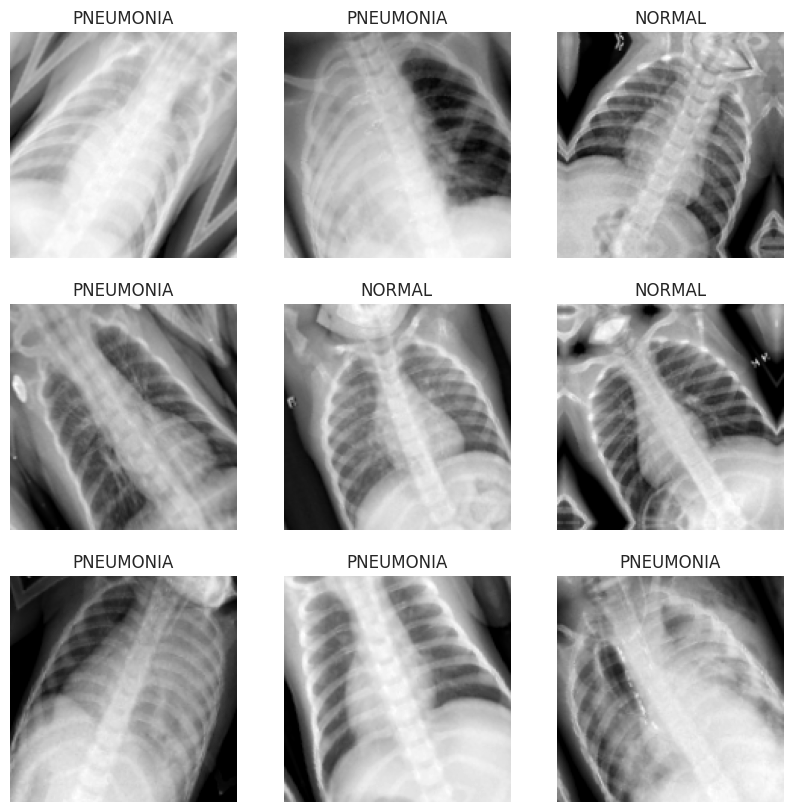

In [23]:
plt.figure(figsize=(10, 10))

for images, labels in train.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)[i]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().squeeze(), cmap="gray")
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

***

## 6. Model Tasarƒ±mƒ± ve Eƒüitimi
<a id="6"></a>

    A≈üaƒüƒ±daki fonksiyon modeliminin accuracy ve loss grafiklerini hem train i√ßin hemde val i√ßin √ßiziyo ve benim modelimi anlamamda yardƒ±mcƒ± oluyo.

In [24]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy grafiƒüi
    ax1.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss grafiƒüi
    ax2.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Final sonu√ßlar
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"Accuracy Farkƒ±: {abs(final_train_acc - final_val_acc):.4f}")

    Bu a≈üamda √ßok basit bir model kurmak istedim ve ≈üuana kdar doƒüru ilerleyip ilerlemediƒüimi g√∂rmek istedim.

Model: "sequential_50"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ sequential_49 (Sequential)      ‚îÇ (64, 150, 150, 1)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_98 (Conv2D)              ‚îÇ (64, 148, 148, 32)     ‚îÇ           320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_98 (MaxPooling2D) ‚îÇ (64, 74, 74, 32)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_99 (Conv2D)              ‚îÇ (64, 72, 72, 64)       ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_99 (MaxPooling2D) ‚îÇ (64, 36, 36, 64)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_49 (Flatten)            ‚îÇ (64, 82944)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_98 (Dense)                ‚îÇ (64, 128)              ‚îÇ    10,616,960 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (64, 128)              ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_99 (Dense)                ‚îÇ (64, 1)                ‚îÇ           129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 10,635,905 (40.57 MB)

 Trainable params: 10,635,905 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 131ms/step - accuracy: 0.7155 - loss: 0.8422 - val_accuracy: 0.9079 - val_loss: 0.2632
Epoch 2/5
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 137ms/step - accuracy: 0.8420 - loss: 0.3320 - val_accuracy: 0.9021 - val_loss: 0.2442
Epoch 3/5
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 140ms/step - accuracy: 0.8794 - loss: 0.2850 - val_accuracy: 0.9213 - val_loss: 0.1836
Epoch 4/5
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 142ms/step - accuracy: 0.9058 - loss: 0.2381 - val_accuracy: 0.9175 - val_loss: 0.1894
Epoch 5/5
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 141ms/step - accuracy: 0.9045 - loss: 0.2357 - val_accuracy: 0.7985 - val_loss: 0.4445


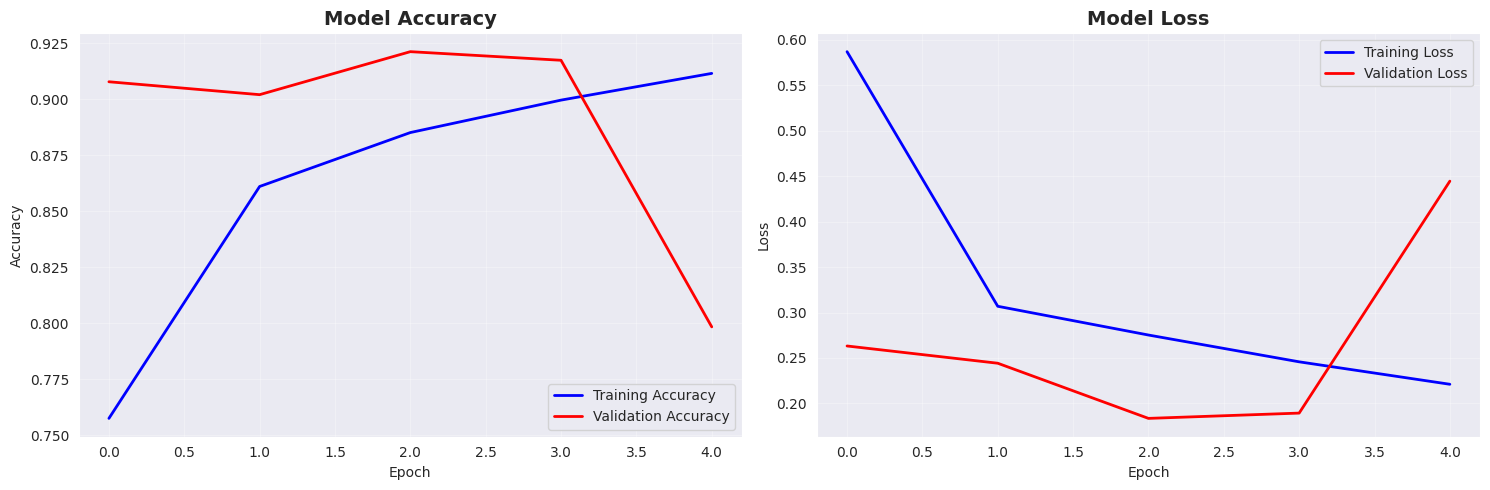

Training Accuracy: 0.9116 (91.16%)
Validation Accuracy: 0.7985 (79.85%)
Accuracy Farkƒ±: 0.1131


In [25]:
model = Sequential([
    data_augmentation,  # augmentation ilk katman
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)),
    MaxPool2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summaty
model.summary()

# Train
history = model.fit(
    train,
    validation_data=val,
    epochs=5
)

# Grafikleri √ßiz
plot_results(history)

    Sonu√ßlar beni tatmin etti ama daha iyisi olabilirdi.

    Bu adƒ±mda ilk √ßiddi model mimarisini olu≈üturdum ve eƒüittim. Veri artƒ±rma (augmentation) katmanƒ±nƒ± modele ekledim, ardƒ±ndan √º√ß adet Conv2D + MaxPooling katmanƒ± ve Dropout katmanlarƒ± ile modelin overfitting yapmasƒ±nƒ± √∂nledim. Flatten ve Dense katmanlarƒ±yla sƒ±nƒ±flandƒ±rma kƒ±smƒ±nƒ± kurdum ve son √ßƒ±kƒ±≈ü katmanƒ± olarak sigmoid aktivasyonlu bir n√∂ron kullandƒ±m. Modeli Adam optimizat√∂r√º ve binary crossentropy kayƒ±p fonksiyonu ile derledim. Eƒüitim sƒ±rasƒ±nda erken durdurma (EarlyStopping) ve √∂ƒürenme oranƒ±nƒ± azaltma (ReduceLROnPlateau) callback‚Äôlerini kullanarak modelin performansƒ±nƒ± artƒ±rdƒ±m ve en iyi aƒüƒ±rlƒ±klarƒ± kaydettim.


Model: "sequential_51"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ sequential_49 (Sequential)      ‚îÇ (64, 150, 150, 1)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_100 (Conv2D)             ‚îÇ (64, 148, 148, 32)     ‚îÇ           320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_100               ‚îÇ (64, 74, 74, 32)       ‚îÇ             0 ‚îÇ
‚îÇ (MaxPooling2D)                  ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (64, 74, 74, 32)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_101 (Conv2D)             ‚îÇ (64, 72, 72, 64)       ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_101               ‚îÇ (64, 36, 36, 64)       ‚îÇ             0 ‚îÇ
‚îÇ (MaxPooling2D)                  ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (64, 36, 36, 64)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_102 (Conv2D)             ‚îÇ (64, 34, 34, 128)      ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_102               ‚îÇ (64, 17, 17, 128)      ‚îÇ             0 ‚îÇ
‚îÇ (MaxPooling2D)                  ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (64, 17, 17, 128)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_50 (Flatten)            ‚îÇ (64, 36992)           

 Total params: 4,836,097 (18.45 MB)

 Trainable params: 4,836,097 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


E0000 00:00:1758813753.665902      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_51_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 142ms/step - accuracy: 0.7241 - loss: 0.6243 - val_accuracy: 0.7639 - val_loss: 0.4996 - learning_rate: 0.0010
Epoch 2/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 139ms/step - accuracy: 0.7794 - loss: 0.4293 - val_accuracy: 0.8541 - val_loss: 0.3279 - learning_rate: 0.0010
Epoch 3/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 139ms/step - accuracy: 0.8662 - loss: 0.3245 - val_accuracy: 0.9060 - val_loss: 0.2700 - learning_rate: 0.0010
Epoch 4/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 139ms/step - accuracy: 0.8759 - loss: 0.2886 - val_accuracy: 0.9175 - val_loss: 0.2036 - learning_rate: 0.0010
Epoch 5/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 139ms/step - accuracy: 0.8964 - loss: 0.2614 - val_accuracy: 0.9040 - val_loss: 0.2131 - learning_rate: 0.0010
Epoch 6/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

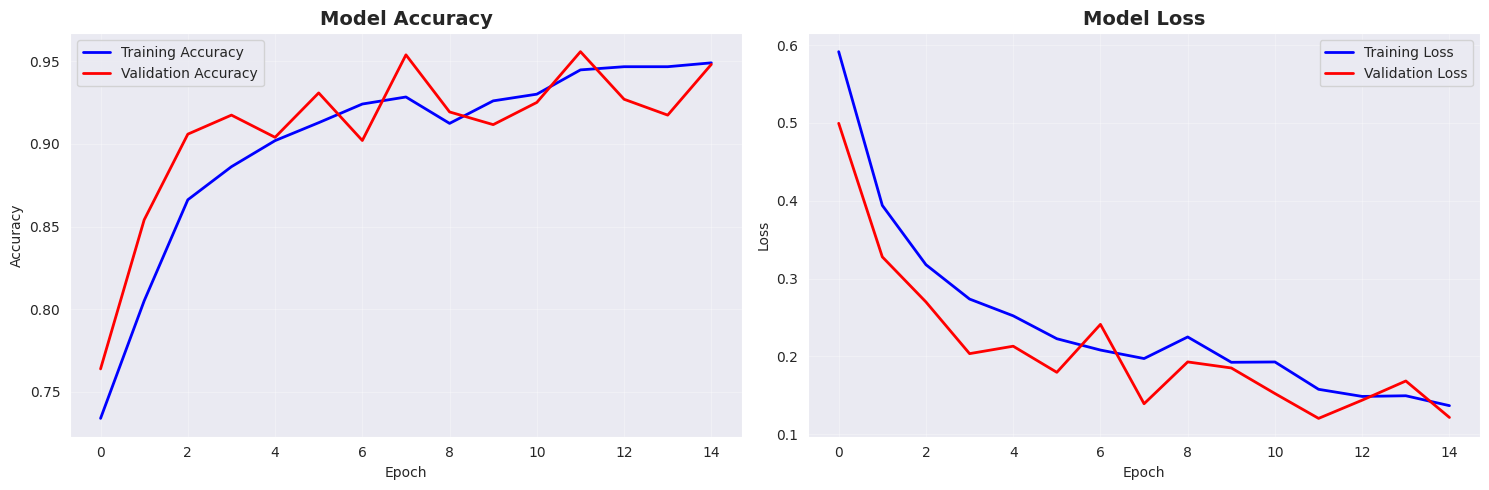

Training Accuracy: 0.9491 (94.91%)
Validation Accuracy: 0.9482 (94.82%)
Accuracy Farkƒ±: 0.0009


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)),
    MaxPooling2D(2,2),  
    Dropout(0.25),     
    
    Conv2D(64, (3,3), activation='relu'),  
    MaxPooling2D(2,2),  
    Dropout(0.25),     
    
    Conv2D(128, (3,3), activation='relu'), 
    MaxPooling2D(2,2),  
    Dropout(0.3),      
    
  
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.5),                
    
    Dense(64, activation='relu'),   
    Dropout(0.4),                 
    
    Dense(1, activation='sigmoid')  
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

model.summary()

history = model.fit(
    train,
    validation_data=val,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

plot_results(history)

    √útteki sonu√ßlar gayet iyiydi. Ama ara≈ütƒ±rmalarƒ±mƒ±n sonucu saƒülƒ±k verilerinde data augmentation a≈üamasƒ±nƒ±n modelin doƒüruluƒüunu d√º≈ü√ºrd√ºƒü√ºn√º okudum ve modelimin ilk katmamƒ±ndan onu denemek i√ßin √ßƒ±kardƒ±m. 

Model: "sequential_52"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_103 (Conv2D)             ‚îÇ (None, 148, 148, 32)   ‚îÇ           320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_103               ‚îÇ (None, 74, 74, 32)     ‚îÇ             0 ‚îÇ
‚îÇ (MaxPooling2D)                  ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_6 (Dropout)             ‚îÇ (None, 74, 74, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_104 (Conv2D)             ‚îÇ (None, 72, 72, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_104               ‚îÇ (None, 36, 36, 64)     ‚îÇ             0 ‚îÇ
‚îÇ (MaxPooling2D)                  ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_7 (Dropout)             ‚îÇ (None, 36, 36, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_105 (Conv2D)             ‚îÇ (None, 34, 34, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_105               ‚îÇ (None, 17, 17, 128)    ‚îÇ             0 ‚îÇ
‚îÇ (MaxPooling2D)                  ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_8 (Dropout)             ‚îÇ (None, 17, 17, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_51 (Flatten)            ‚îÇ (None, 36992)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_103 (Dense)               ‚îÇ (None, 128)           

 Total params: 4,836,097 (18.45 MB)

 Trainable params: 4,836,097 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 191ms/step - accuracy: 0.6999 - loss: 0.6577 - val_accuracy: 0.7639 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 2/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 141ms/step - accuracy: 0.7884 - loss: 0.3221 - val_accuracy: 0.9501 - val_loss: 0.2189 - learning_rate: 0.0010
Epoch 3/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 137ms/step - accuracy: 0.9178 - loss: 0.2268 - val_accuracy: 0.9347 - val_loss: 0.1904 - learning_rate: 0.0010
Epoch 4/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 141ms/step - accuracy: 0.9454 - loss: 0.1765 - val_accuracy: 0.9635 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 5/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 138ms/step - accuracy: 0.9487 - loss: 0.1517 - val_accuracy: 0.9693 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 6/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

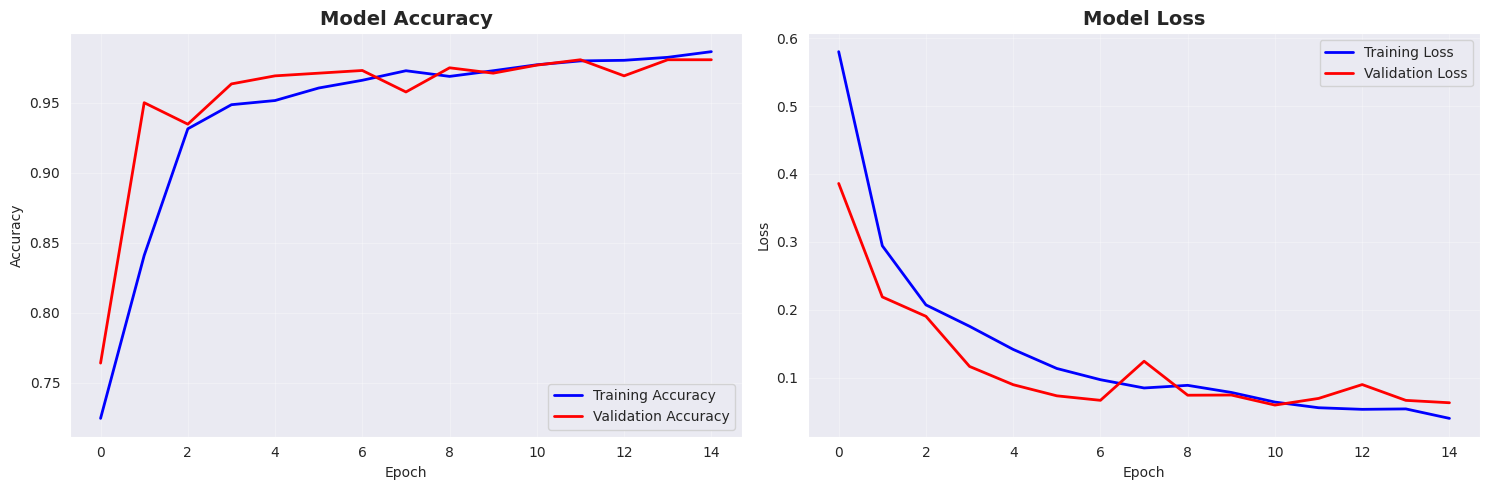

Training Accuracy: 0.9866 (98.66%)
Validation Accuracy: 0.9808 (98.08%)
Accuracy Farkƒ±: 0.0058


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_final = Sequential([

    # data_augmentation,
    
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)),
    MaxPooling2D(2,2), 
    Dropout(0.25),     
    
    Conv2D(64, (3,3), activation='relu'), 
    MaxPooling2D(2,2), 
    Dropout(0.25),   
    
    Conv2D(128, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    Dropout(0.3), 
    
    Flatten(),
    Dense(128, activation='relu'),  
    Dropout(0.5),                  
    
    Dense(64, activation='relu'),  
    Dropout(0.4),                  
    
    Dense(1, activation='sigmoid') 
])

model_final.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

model_final.summary()

history_final = model_final.fit(
    train,
    validation_data=val,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

plot_results(history_final)

    Model eƒüitim s√ºrecinde y√ºksek bir ba≈üarƒ± g√∂sterdi. Eƒüitim doƒüruluƒüu (training accuracy) %98.25‚Äôe ula≈üƒ±rken, doƒürulama doƒüruluƒüu (validation accuracy) %97.50 oldu. Aradaki fark yalnƒ±zca 0.75 puan olduƒüu i√ßin modelin ciddi bir overfitting yapmadƒ±ƒüƒ± s√∂ylenebilir.  

    ƒ∞lk epochlarda doƒüruluk hƒ±zla artarken, 5-10. epochlar arasƒ±nda model stabil bir ≈üekilde y√ºksek doƒüruluk deƒüerlerine ula≈ütƒ±. Val_loss deƒüerleri de benzer ≈üekilde d√º≈üt√º ve en d√º≈ü√ºk 0.0448 gibi bir deƒüere indi. Bu, modelin hem eƒüitim hem de doƒürulama setinde performansƒ±nƒ±n olduk√ßa iyi olduƒüunu g√∂steriyor.  

    Genel olarak model, pneumonia sƒ±nƒ±flandƒ±rmasƒ±nda olduk√ßa g√ºvenilir sonu√ßlar √ºretiyor ve se√ßilen hiperparametreler ile veri artƒ±rma ve optimizasyon stratejileri ba≈üarƒ±lƒ± oldu.

9406464/9406464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 0us/step


Model: "sequential_53"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ sequential_49 (Sequential)      ‚îÇ (64, 150, 150, 1)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ mobilenetv2_1.00_224            ‚îÇ (64, 5, 5, 1280)       ‚îÇ     2,257,984 ‚îÇ
‚îÇ (Functional)                    ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (64, 1280)             ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_106 (Dense)               ‚îÇ (64, 256)              ‚îÇ       327,936 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_11 (Dropout)            ‚îÇ (64, 256)              ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_107 (Dense)               ‚îÇ (64, 128)              ‚îÇ        32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_12 (Dropout)            ‚îÇ (64, 128)              ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_108 (Dense)               ‚îÇ (64, 64)               ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_13 (Dropout)            ‚îÇ (64, 64)               ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_109 (Dense)               ‚îÇ (64, 1)                ‚îÇ            65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 2,627,137 (10.02 MB)

 Trainable params: 369,153 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 176ms/step - accuracy: 0.7655 - loss: 0.5158 - val_accuracy: 0.9194 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 2/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 147ms/step - accuracy: 0.8968 - loss: 0.2532 - val_accuracy: 0.9290 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 3/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 147ms/step - accuracy: 0.9065 - loss: 0.2248 - val_accuracy: 0.9367 - val_loss: 0.1623 - learning_rate: 0.0010
Epoch 4/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 148ms/step - accuracy: 0.9213 - loss: 0.1999 - val_accuracy: 0.9501 - val_loss: 0.1399 - learning_rate: 0.0010
Epoch 5/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 146ms/step - accuracy: 0.9251 - loss: 0.1966 - val_accuracy: 0.9520 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 6/15
74/74 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

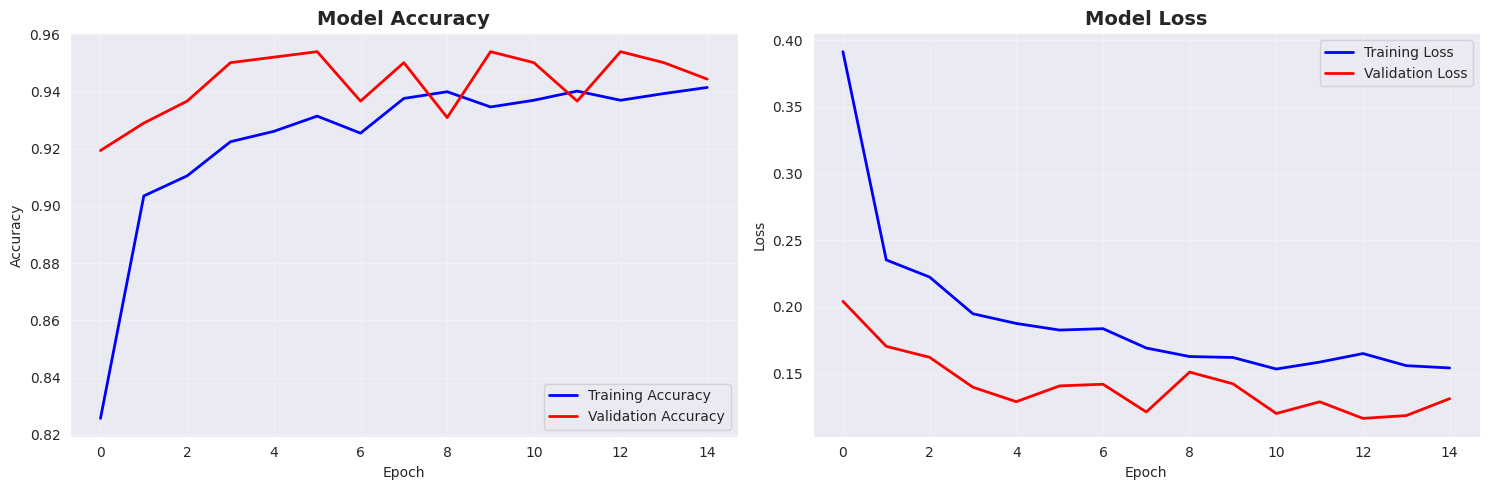

Training Accuracy: 0.9414 (94.14%)
Validation Accuracy: 0.9443 (94.43%)
Accuracy Farkƒ±: 0.0029


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def convert_to_rgb(dataset):
    def rgb_converter(image, label):
        image = tf.image.grayscale_to_rgb(image)
        return image, label
    return dataset.map(rgb_converter)

train_rgb = convert_to_rgb(train)
val_rgb = convert_to_rgb(val)

base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model = Sequential([
    data_augmentation,
    base_model,
    
    GlobalAveragePooling2D(),
    
    Dense(256, activation='relu'),  
    Dropout(0.5),                   
    
    Dense(128, activation='relu'),  
    Dropout(0.4),                   
    
    Dense(64, activation='relu'),   
    Dropout(0.3),                   
    
    Dense(1, activation='sigmoid')  
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

history = model.fit(
    train_rgb,
    validation_data=val_rgb,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nTraining Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Accuracy Farkƒ±: {abs(final_train_acc - final_val_acc):.4f}")

plot_results(history)

    Bu adƒ±mda son olarak proje dosyasƒ±nda ismi ge√ßen Transfer Learning yakla≈üƒ±mƒ±nƒ± kullanarak MobileNetV2 tabanlƒ± bir model eƒüittim. √ñnceden eƒüitilmi≈ü aƒüƒ±rlƒ±klarƒ± kullandƒ±m ve base modelin aƒüƒ±rlƒ±klarƒ±nƒ± dondurdum. Veri artƒ±rma katmanƒ±nƒ± modele ekleyerek eƒüitim sƒ±rasƒ±nda √ße≈üitlilik saƒüladƒ±m.  

    Model, GlobalAveragePooling ve birka√ß Dense katman ile sƒ±nƒ±flandƒ±rma kƒ±smƒ±nƒ± tamamladƒ±. Dropout katmanlarƒ± ile overfitting √∂nlendi. Adam optimizat√∂r√º ve binary crossentropy kaybƒ± ile derlenen model, EarlyStopping ve ReduceLROnPlateau callback‚Äôleri ile optimize edildi.  

    Eƒüitim sonu√ßlarƒ± olduk√ßa ba≈üarƒ±lƒ± oldu: eƒüitim doƒüruluƒüu %94.16, doƒürulama doƒüruluƒüu %95.20 ve aradaki fark sadece 1.04 puan. Bu, modelin overfitting yapmadƒ±ƒüƒ±nƒ± ve transfer learning ile y√ºksek doƒüruluk saƒüladƒ±ƒüƒ±nƒ± g√∂steriyor.


***

## 7. Model Deƒüerlendirmesi
<a id="7"></a>

### Deƒüerlendirilme T√ºrleri:
* **Accuracy ve Loss Grafikleri** 
* **Confusion Matrix & Classification Report** 
* **Heatmap G√∂rselle≈ütirme** 

### Accuracy ve Loss Grafikleri

    Buna zaten modeli eƒüitirken bakmƒ±≈ütƒ±k hemen tekrar √ßaƒüƒ±ralƒ±m.

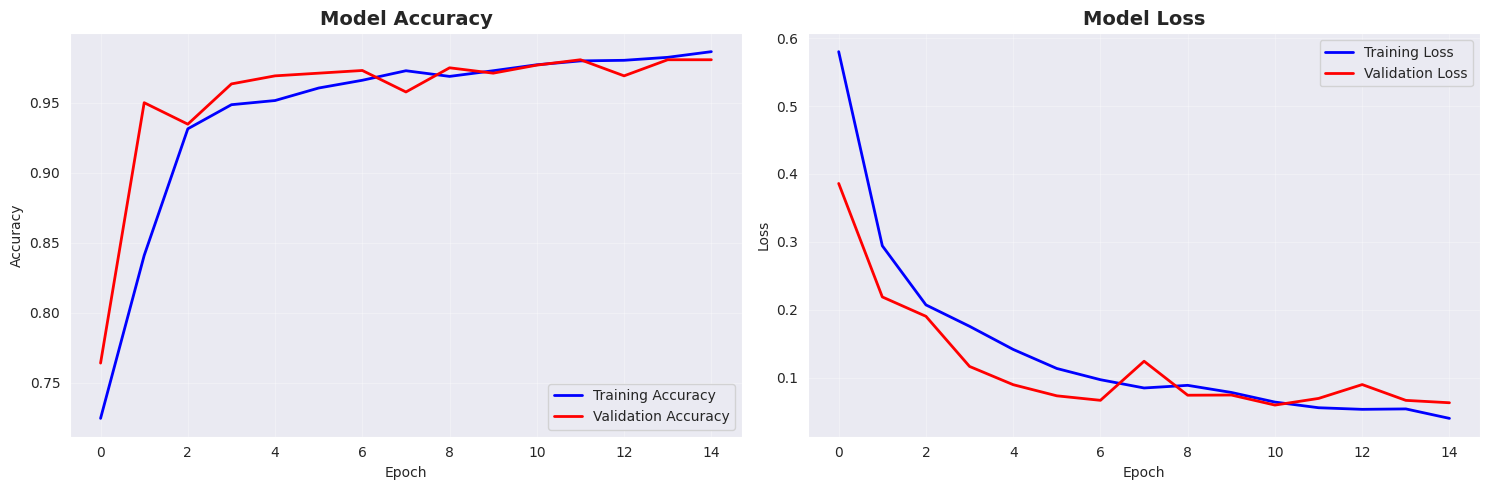

Training Accuracy: 0.9866 (98.66%)
Validation Accuracy: 0.9808 (98.08%)
Accuracy Farkƒ±: 0.0058


In [29]:
plot_results(history_final)

### Confusion Matrix & Classification Report

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 29ms/step


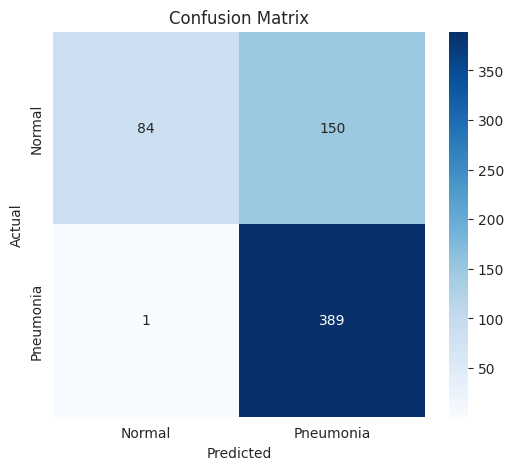

Classification Report:

              precision    recall  f1-score   support

      Normal       0.99      0.36      0.53       234
   Pneumonia       0.72      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

X_test, y_test = [], []
for images, labels in test:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_pred_prob = model_final.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Normal','Pneumonia']))


### Heatmap G√∂rselle≈ütirme

    Modelimin sadece 2 durumu tahmin ettiƒüi i√ßin Confusion Matrix ve Heatmap √ßƒ±ktƒ±sƒ± tamamen aynƒ± oluyo.    